# Incidence de la varicelle depuis Sentinelle

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import requests
import os
import glob
from datetime import datetime

Les données de l'incidence de la varicelle sont disponibles du site Web du [Réseau Sentinelles](http://www.sentiweb.fr/). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1990 et toujours en update regulier.

In [7]:
data_url = "http://www.sentiweb.fr/datasets/all/inc-7-PAY.csv"
local_file_pattern = "-sentinelle-varicelle.csv"

In [17]:
# detect latest version of local data 
files = glob.glob(f'*{local_file_pattern}')

if files == [] : 
    print(f'No local file detected using pattern {local_file_pattern}, ... Downloading up to date file')
    
    # checking if URL is still active 
    url_file = requests.get(data_url, timeout = 50)
    assert url_file.raise_for_status() != 200, f'Provided URL is unreachable or returned {url_file.status_code}'

    # loading file from URL
    url_content = url_file.content


    with open(f'{datetime.today().strftime("%Y%m%d")}{local_file_pattern}', 'wb') as f:
        f.write(url_content)
    raw_data = f'{datetime.today().strftime("%Y%m%d")}{local_file_pattern}'
else : 
    print(f'Detected {len(files)} file(s) with pattern {local_file_pattern}')
    latest = max(files) 
    print(f'Using latest : {latest}')
    print('! Consider checking latest data for update, keep original file')
    raw_data = latest
        
raw_data = pd.read_csv(raw_data,  encoding = 'iso-8859-1', skiprows=1)     

raw_data.head()

Detected 1 file(s) with pattern -sentinelle-varicelle.csv
Using latest : 20251210--sentinelle-varicelle.csv
! Consider checking latest data for update, keep original file


week  indicator   inc  inc_low  inc_up  inc100  inc100_low  inc100_up  \
0  202548          7  5654     3398    7910       8           5         11   
1  202547          7  5184     3279    7089       8           5         11   
2  202546          7  3136     1451    4821       5           2          8   
3  202545          7  4733     2070    7396       7           3         11   
4  202544          7  3461     1763    5159       5           2          8   

  geo_insee geo_name  
0        FR   France  
1        FR   France  
2        FR   France  
3        FR   France  
4        FR   France

Y a-t-il des points manquants dans ce jeux de données ? Oui, la semaine 19 de l'année 1989 n'a pas de valeurs associées.

In [22]:
raw_data[raw_data.isnull().any(axis=1)]
data = raw_data.copy()

Pas de donnée manquante dans ce jeux de donnée

In [24]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

Il restent deux petites modifications à faire.

Premièrement, nous définissons les périodes d'observation
comme nouvel index de notre jeux de données. Ceci en fait
une suite chronologique, ce qui sera pratique par la suite.

Deuxièmement, nous trions les points par période, dans
le sens chronologique.

In [27]:
sorted_data = data.set_index('period').sort_index()
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Il ne semble pas y avoir d'incoherence numerique dans le reformattage des periodes du jeux de donnée, effectuons maintenant une inspection visuelle

Reformater `inc` en integer car il a ete apellé en tant que object 

In [30]:
sorted_data['inc']= pd.to_numeric(sorted_data['inc'])
sorted_data['inc'][0]

1143

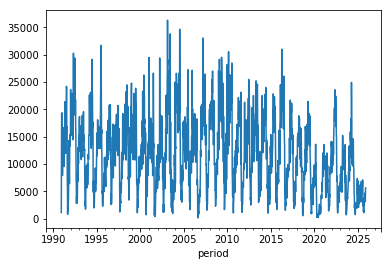

In [32]:
sorted_data['inc'].plot()

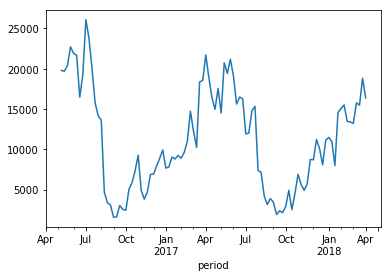

In [37]:
sorted_data['inc'][-500:-400].plot()

Il semble y avoir une periodicité avec un pic en avril - juillet (printemps) et un creux en septembre octobre (automne) qui peux paraitre etre une variation hivernale ou une circulation du virus venu d'ailleur

In [44]:
first_august_week = [pd.Period(pd.Timestamp(y, 10, 1), 'W')
                     for y in range(sorted_data.index[0].year,
                                    sorted_data.index[-1].year)]

In [49]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_august_week[:-1],
                        first_august_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    print(abs(len(one_year)-52))
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

9
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
1


On remarque que certaines année ne sont pas completes particulierement l'année 1990, certaines année possendent une semaine en moins, ce qui peut avoir un impact si certaines année sont proches.  

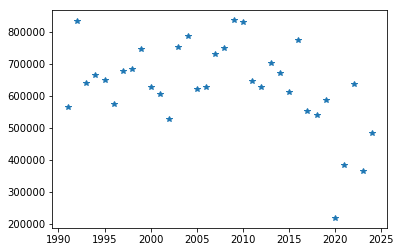

In [47]:
yearly_incidence.plot(style='*')

In [48]:
yearly_incidence.sort_values()

2020    217605
2023    364553
2021    382779
2024    483209
2002    526035
2018    540799
2017    552105
1991    565956
1996    574093
2019    585143
2001    606520
2015    611634
2005    620796
2006    626180
2012    627384
2000    627405
2022    635251
1993    638384
2011    644660
1995    650679
1994    664684
2014    672401
1997    677145
1998    682638
2013    703305
2007    729321
1999    746617
2008    750410
2003    752007
2016    775321
2004    786328
2010    830938
1992    834566
2009    836245
dtype: int64